In [13]:
import numpy as np
import pandas as pd
import altair as alt

import concensus_clustering

from copy import deepcopy

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
feature_categories = [
    'shape',
    'firstorder',
    'glcm',
    'glrlm',
    'glszm',
    'gldm',
    'ngtdm',
    'PETparam', 
    'clinical'
]

In [3]:
def category_counts(_):
    
    return {
        'shape': 0,
        'firstorder': 0,
        'glcm': 0,
        'glrlm': 0,
        'glszm': 0,
        'gldm': 0,
        'ngtdm': 0,
        'PETparam': 0,
        'clinical': 0,
    }


def _update_count(pet_output, ct_output, key):

    if 'PET' in key:
        pet_output[key] += 1
    else:
        ct_output[key] += 1
            
    return pet_output, ct_output


def _norm_count(pet_output, ct_output, key, tot_counts):
    
    if 'PET' in key:
        pet_output[key] /= tot_counts[key]
    else:
        ct_output[key] /= tot_counts[key]
            
    return pet_output, ct_output


def to_feature_categories(cluster_indices):
    
    pet_output = category_counts(None)
    ct_output = category_counts(None)
    
    
    for label in X.columns[cluster_indices]:
        if 'shape' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'shape')
        elif 'firstorder' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'firstorder')
        elif 'glcm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glcm')
        elif 'glrlm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glrlm')
        elif 'glszm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glszm')
        elif 'gldm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'gldm')
        elif 'ngtdm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'ngtdm')
        elif 'PETparam' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'PETparam')
        else:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'clinical')
        
    feature_counts = {
        'shape': 13,
        'firstorder': 54,
        'glcm': 69,
        'glrlm': 48,
        'glszm': 48,
        'gldm': 42,
        'ngtdm': 15,
        'PETparam': 3, 
        'clinical': 42
    }
    for label in feature_counts.keys():
        pet_output, ct_output = _norm_count(pet_output, ct_output, label, feature_counts)

    return pet_output, ct_output


def meta_score(scores):
    """The harmonic mean of multiple score metrics.""" 
    
    inv_scores = sum(1.0 / np.array(scores, dtype=float))
        
    return len(scores) / inv_scores


def biclusters(model, X, param_config):
    # Create Bicluster instances tracking detected clusters.
    
    # Start fresh with each clustering.
    _model = deepcopy(model)
    
    # Set number of clusters to detect and fit model to data.
    _model.set_params(**param_config)
    _model.fit(X)

    rows, cols = _model.rows_, _model.columns_
    # Sanity check.
    assert np.shape(rows)[0] == np.shape(cols)[0]
    
    biclusters = concensus_clustering.Biclusters(
        rows=rows, cols=cols, data=X
    )
    return biclusters


def checker_coords(model, num_clusters):
    # Collect coordinates for biclusters with a checkerborad structure.
    
    tot_num_clusters = num_clusters[0] * num_clusters[1]
    coords = pd.DataFrame(
        np.zeros((tot_num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    
    num, prev_rows = 0, 0
    for row_num in range(num_clusters[0]):
        nrows = np.sum(model.rows_[row_num])

        prev_cols = 0
        for col_num in range(num_clusters[1]):
            ncols = np.sum(model.columns_[col_num])

            coords.iloc[num, 0] = prev_rows + 1
            coords.iloc[num, 1] = prev_rows + nrows
            coords.iloc[num, 2] = prev_cols
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows - 1

    return coords


def bic_coords(model, num_clusters):
    # Collect coordinates for block diagonal biclusters.

    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    prev_rows, prev_cols = 0, 0
    for num, row_bic in enumerate(model.rows_):
        num_rows = np.sum(row_bic)
        num_cols = np.sum(model.columns_[num])

        coords.iloc[num, 0] = prev_rows
        coords.iloc[num, 1] = prev_rows + num_rows
        coords.iloc[num, 2] = prev_cols
        coords.iloc[num, 3] = prev_cols + num_cols

        prev_rows += num_rows
        prev_cols += num_cols

    return coords

# Dataset

In [4]:
SEED = 0 

In [7]:
_y = pd.read_csv('./../../data_source/to_analysis/original_images/target_dfs.csv', index_col=0)
y = np.squeeze(_y.values)

X = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv', index_col=0)

y.shape, X.shape

((198,), (198, 553))

In [8]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X.values)
X_std.shape

(198, 553)

# Spectral Biclustering

Ref: Kluger, Yuval, et. al., 2003. Spectral biclustering of microarray data: coclustering genes and conditions.
* [blog](http://www.kemaleren.com/post/spectral-biclustering-part-1/)

In [14]:
np.random.seed(0)
bic_grid = ParameterGrid(
    {'n_clusters': [np.random.choice(np.arange(2, 20), size=2) for _ in range(10)]}
)
bic_scores = {}
for num, bic_param_config in enumerate(bic_grid):
    bic_model = SpectralBiclustering(
        random_state=SEED, method='log', svd_method='arpack'
    )
    bic_clusters = biclusters(bic_model, X_std, bic_param_config)
    bic_scores[num] = bic_clusters.external_metrics

/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divi

In [16]:
# Determine best biclustering config. (number of clusters).
avg_bic_scores = []
for scores in bic_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_bic_scores.append(score)
    
best_config = bic_grid[np.argmin(avg_bic_scores)]
best_config, min(avg_bic_scores)

({'n_clusters': array([2, 5])}, 0.9122524578180476)

In [17]:
# Train model with best config.
bic_model = SpectralBiclustering(
    random_state=SEED, method='log', svd_method='arpack'
)
bic_model.set_params(**best_config)
bic_model.fit(X_std)
bic_row_sorted = X_std[np.argsort(bic_model.row_labels_), :]
bic_fit_data = bic_row_sorted[:, np.argsort(bic_model.column_labels_)]

## Row Clusters

In [18]:
# The proportion of patient outcomes per row bicluster.
bic_row_ids = []
bic_pfs_outcome, bic_not_pfs_outcome = [], []

for bic_row_idx in np.unique(bic_model.row_labels_):
    # Store cluster index.
    bic_row_ids.append(bic_row_idx)
    
    # ID samples belonging to current cluster.
    row_cluster_samples = np.where(bic_model.row_labels_ == bic_row_idx)
    
    # Store fractions of each outcome for current cluster.
    bic_pfs_outcome.append(sum(y[row_cluster_samples] == 0) / np.size(y))
    bic_not_pfs_outcome.append(sum(y[row_cluster_samples] == 1) / np.size(y))
    
sum(bic_pfs_outcome), sum(bic_not_pfs_outcome), len(bic_row_ids)

(0.7525252525252526, 0.24747474747474746, 2)

In [19]:
sorted_cluster_idx = np.concatenate((bic_row_ids, bic_row_ids))
comb_results = np.concatenate((bic_pfs_outcome, bic_not_pfs_outcome))

results_id =  np.concatenate((
    ['Progression-free Survival'] * len(bic_pfs_outcome), 
    ['Other Event'] * len(bic_not_pfs_outcome)
))
df_bic_stats = pd.DataFrame(
    {
        'comb_results': comb_results,
        'results_id': results_id
    },
    index=sorted_cluster_idx,
)
df_bic_stats.head()

,comb_results,results_id
0,0.398990,Progression-free Survival
1,0.353535,Progression-free Survival
0,0.106061,Other Event
1,0.141414,Other Event


In [20]:
sum(df_bic_stats['comb_results'])

1.0

In [21]:
(a, b) = df_bic_stats.groupby('results_id')
a[0], a[1]['comb_results'].sum(), b[0], b[1]['comb_results'].sum()

('Other Event',
 0.24747474747474746,
 'Progression-free Survival',
 0.7525252525252526)

## Column Clusters

In [22]:
# The number of features from each feature category per column bicluster.

pet_category_stats = {}
ct_category_stats = {}

for bic_col_idx in np.unique(bic_model.column_labels_):    
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(bic_model.column_labels_ == bic_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples)
    pet_category_stats[bic_col_idx] = pet_output
    ct_category_stats[bic_col_idx] = ct_output
    
pet_df = pd.DataFrame(pet_category_stats).T
ct_df = pd.DataFrame(ct_category_stats).T

In [23]:
frames = {}
# NB: Not all features can be divided into PET/CT categories.
for pet_col, ct_col in zip(pet_df, ct_df):
    
    
    assert pet_col == ct_col
    if 'clinical' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['clinical']
        
    elif 'shape' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['shape']
    else:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col], pet_df.loc[:, pet_col]],

        )
        frame = frame.T
        frame.columns = ['CT', 'PET']
    
    frame.index = np.arange(frame.index.size) + 1
    frames[ct_col] = frame

frames.keys()

dict_keys(['PETparam', 'clinical', 'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm', 'shape'])

"plt.savefig(\n    './../../../figures/cluster_analysis/row_column_biclusters.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

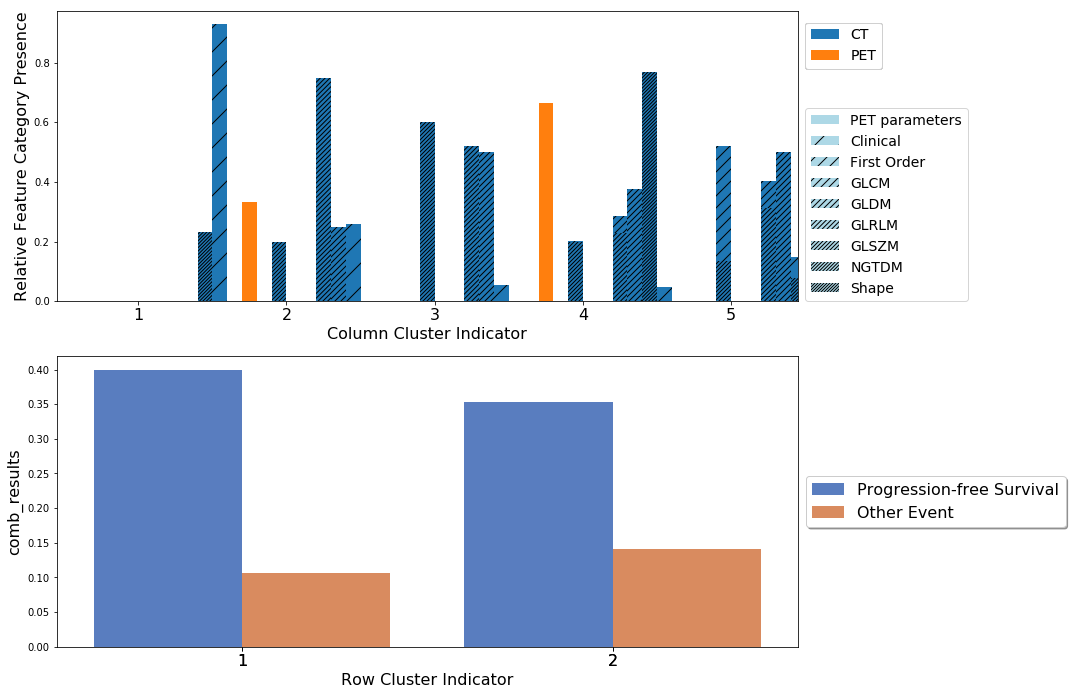

In [24]:
# * Possible to separate patients based on clinical outcomes whilst
#   identifying separating features?
# * Hue row (patient) clusters according to outcome. Capable of producing clusters with
#   pure outcomes? If so, which features separates a pure PFS outcome cluster from a 
#   cluster with no PFS outcomes?


H = '/'
labels = [
    'PET parameters', 'Clinical', 'First Order', 
    'GLCM', 'GLDM', 'GLRLM', 'GLSZM', 'NGTDM', 
    'Shape'
]

n_df = len(frames.keys())
n_col = len(list(frames.values())[0].columns) 
n_ind = len(list(frames.values())[0].index)

fig, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axis1.set_ylabel('Relative Feature Category Presence', fontsize=16)
axis1.set_xlabel('Column Cluster Indicator', fontsize=16)
for df in frames.values():
    df.plot(
        kind='bar',
        linewidth=0,
        stacked=True,
        ax=axis1,
        legend=False,
        grid=False
    )
    h, l = axis1.get_legend_handles_labels() 
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: 
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) 
                rect.set_width(1 / float(n_df + 1))

    axis1.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axis1.set_xticklabels(df.index, rotation=0, fontsize=16)
    
    n = []        
    for i in range(n_df):
        n.append(axis1.bar(0, 0, color='lightblue', hatch=H * i))
    
    l1 = axis1.legend(h[:n_col], l[:n_col], loc=[1.01, 0.8], fontsize=14)
    l2 = axis1.legend(n, labels, loc=[1.01, 0], fontsize=14) 
    axis1.add_artist(l1)
    

axis2.set_xlabel('Row Cluster Indicator', fontsize=16)
axis2.set_ylabel('Relative Outcome Category Presence', fontsize=16)
sns.barplot(
    x=sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_bic_stats,
    palette='muted',
    ax=axis2
)

axis2.legend(
    fontsize=16,
    loc='center left', 
    bbox_to_anchor=(1, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True
)

axis2.set_xticks(sorted_cluster_idx)
axis2.set_xticklabels(sorted_cluster_idx + 1, rotation=0, fontsize=16)

plt.tight_layout()

"""plt.savefig(
    './../../../figures/cluster_analysis/row_column_biclusters.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

"\nplt.savefig(\n    './../../../figures/cluster_analysis/bicmap.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

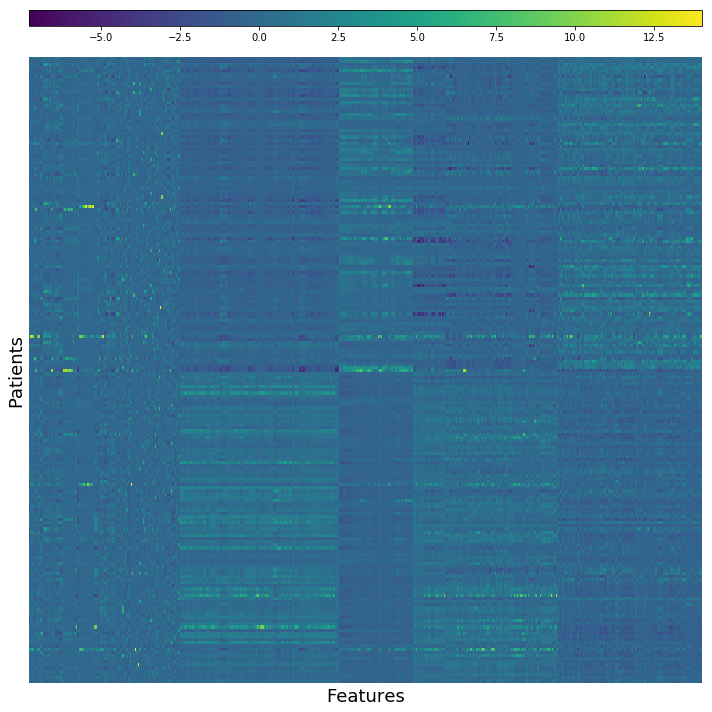

In [25]:
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, figsize=(10, 10),  
    gridspec_kw={'height_ratios':[0.025, 1]}
)
sns.heatmap(
    bic_fit_data, 
    ax=map_ax, 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(bic_fit_data), 
    vmax=np.max(bic_fit_data),
    cbar=False
)
#coords = checker_coords(bic_model, best_config['n_clusters'])
#for num in coords.index:
#    plt.plot(
#        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
#        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
#        linewidth=2, c='orangered' #darkred
#)
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
map_ax.set_xlabel('Features', fontsize=18)
map_ax.set_ylabel('Patients', fontsize=18)
map_ax.axes.get_xaxis().set_ticks([])
map_ax.axes.get_yaxis().set_ticks([])

plt.tight_layout()

"""
plt.savefig(
    './../../../figures/cluster_analysis/bicmap.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""